In [26]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import subprocess

from dotenv import load_dotenv
from scipy import stats

## Функции для анализа данных 

In [55]:
def create_data_frame(all_data):
    # Преобразуем данные в DataFrame
    all_messages = []
    for connection in all_data:
        for message in connection["data"]:
            all_messages.append({
                "connection_id": connection["connection_id"],
                "update_id": message["u"],
                "receive_time": message["receive_time"],
                "event_time": message["E"]
            })
    
    df = pd.DataFrame(all_messages)
    df["delay"] = df["receive_time"] - df["event_time"]
    return df

In [57]:
def analyze_data(all_data):
    df = create_data_frame(all_data)
    # Построение графиков распределения задержек
    plt.figure(figsize=(12, 8))
    for connection_id in range(5):
        subset = df[df["connection_id"] == connection_id]
        sns.kdeplot(subset["delay"], label=f"Connection {connection_id}", fill=True)

    plt.title("Распределение задержек по соединениям")
    plt.xlabel("Задержка (мс)")
    plt.ylabel("Плотность")
    plt.legend()
    plt.show()

    # Анализ доли быстрых апдейтов
    fast_updates = df.loc[df.groupby("update_id")["delay"].idxmin()]["connection_id"].value_counts()
    fast_updates_ratio = fast_updates / fast_updates.sum()

    
    print("Доля быстрых обновлений по соединениям:")
    print(fast_updates_ratio)

    # Статистические тесты
    delays_by_connection = [df[df["connection_id"] == conn_id]["delay"] for conn_id in range(5)]

    # Тест на равенство математических ожиданий
    f_stat, p_value_mean = stats.f_oneway(*delays_by_connection)
    print(f"ANOVA тест на равенство средних значений задержек: F-статистика = {f_stat}, p-значение = {p_value_mean}")

    # Тест на равенство стандартных отклонений
    f_stat_var, p_value_var = stats.bartlett(*delays_by_connection)
    print(f"Тест Bartlett'а на равенство дисперсий задержек: F-статистика = {f_stat_var}, p-значение = {p_value_var}")

## Анализ параметров c использованием асинхронного окружения (Async)

In [51]:
load_dotenv()
OUTPUT_FILE = os.getenv('OUTPUT_FILE_1')

In [42]:
subprocess.run(['python', 'api_async.py'], capture_output=True, text=True)

CompletedProcess(args=['python', 'binance_api_async.py'], returncode=0, stdout='Starting data collection...\nConnection 2: Connected to WebSocket.\nConnection 4: Connected to WebSocket.\nConnection 0: Connected to WebSocket.\nConnection 3: Connected to WebSocket.\nConnection 1: Connected to WebSocket.\nConnection 2: Successfully subscribed to btcusdt@bookTicker.\nConnection 4: Successfully subscribed to btcusdt@bookTicker.\nConnection 0: Successfully subscribed to btcusdt@bookTicker.\nConnection 3: Successfully subscribed to btcusdt@bookTicker.\nConnection 1: Successfully subscribed to btcusdt@bookTicker.\nCollected data saved to ./binance_data_1.json\n', stderr='')

In [52]:
with open(OUTPUT_FILE, "r") as f:
    all_data = json.load(f)

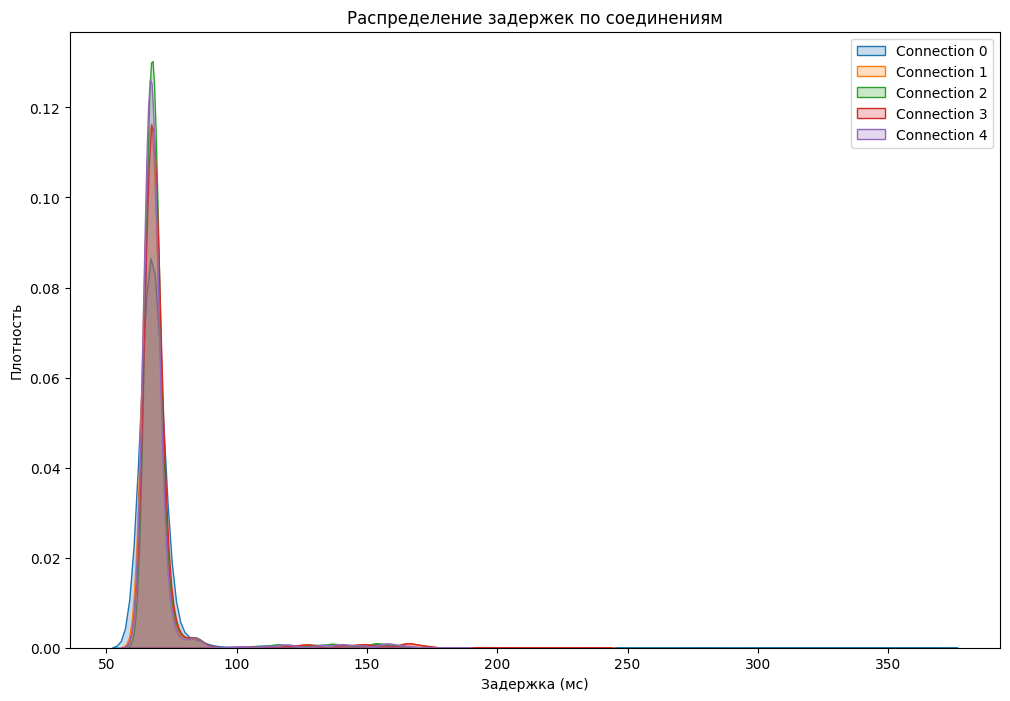

Доля быстрых обновлений по соединениям:
connection_id
0    0.769799
1    0.130390
4    0.058066
2    0.028174
3    0.013572
Name: count, dtype: float64
ANOVA тест на равенство средних значений задержек: F-статистика = 7.838990237351547, p-значение = 2.609231860293728e-06
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 2193.6483101730123, p-значение = 0.0


In [54]:
# Запускаем анализ
analyze_data(all_data)

### Вывод:
* График: Распределение задержек более равномерно, что указывает на более широкий разброс значений. Это может говорить о более высокой гибкости подхода, но также и о меньшей предсказуемости. Плотность ниже (0.12-0.13), что может свидетельствовать о наличии большего числа "выбросов" или редких больших задержек. Эти задержки могут быть связаны с конкурентной обработкой событий или с загрузкой системы в процессе выполнения ассинхроного кода.
* Доля быстрых обновлений: Соединение 0 лидирует с 76.98% быстрых обновлений, но доли остальных соединений сильно различаются, что подтверждает выводы о большей вариативности в асинхронном подходе.
* ANOVA тест: F-статистика = 7.84, p-значение = 2.6e-06. Результаты показывают значимые различия между средними задержками соединений. Несмотря на то, что различия есть и они статистически значимы (p-значение также указывает на отклонение нулевой гипотезы), они не явно выражены.
* Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 2193.6483101730123, p-значение = 0.0 Тест Бартлетта используется для проверки гипотезы о том, что несколько выборок происходят из распределений с одинаковыми дисперсиями. Эти результаты указывают на значительные различия в дисперсиях задержек между разными соединениями. Достаточно высокая F-статистика и p-значение, стремящееся к нулю, свидетельствуют о том, что дисперсии значительно отличаются, что может указывать на различные уровни стабильности или вариабельности задержек в разных процессах.

# Анализ параметров без использования асинхронного окружения (Multiprocessing)

In [45]:
subprocess.run(['python', 'api_mp.py'], capture_output=True, text=True)

CompletedProcess(args=['python', 'binance_api_multiprocessing.py'], returncode=0, stdout='Starting data collection...\nConnection 2: Connected to WebSocket.\nConnection 3: Connected to WebSocket.\nConnection 1: Connected to WebSocket.\nConnection 4: Connected to WebSocket.\nConnection 0: Connected to WebSocket.\nCollected data saved to ./binance_data_2.json\n', stderr='')

In [88]:
load_dotenv(override=True)
OUTPUT_FILE = os.getenv('OUTPUT_FILE_2')

In [59]:
with open(OUTPUT_FILE, "r") as f:
    all_data = json.load(f)

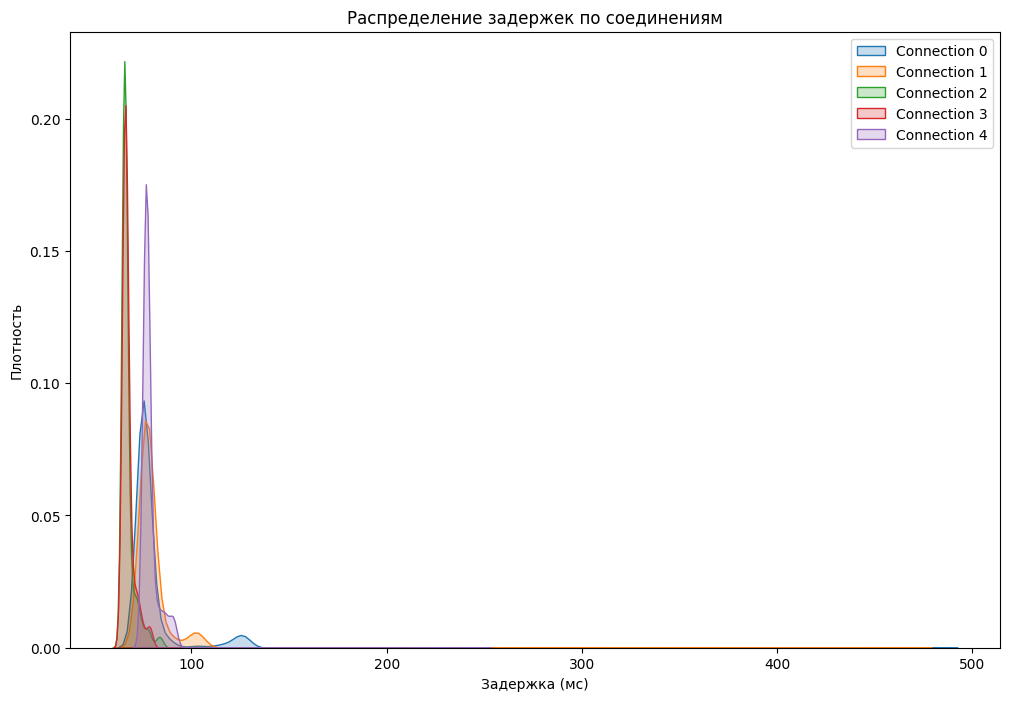

Доля быстрых обновлений по соединениям:
connection_id
2    0.905475
3    0.091959
0    0.002352
1    0.000214
Name: count, dtype: float64
ANOVA тест на равенство средних значений задержек: F-статистика = 1171.0881010237363, p-значение = 0.0
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 10843.128965405884, p-значение = 0.0


In [48]:
analyze_data(all_data)

### Вывод
* График: Распределение задержек более сконцентрировано, что видно по более высоким пикам плотности. Это говорит о том, что многопроцессорный подход имеет меньшее рассеяние задержек, и большинство задержек укладываются в узкий диапазон значений. Более высокая плотность (0.2 и выше) указывает на стабильность и предсказуемость задержек, что является плюсом для задач, требующих надежности и минимальных отклонений в обработке данных.
* Доля быстрых обновлений: Соединение 2 демонстрирует значительное преимущество с долей быстрых обновлений ~90.5%. Это говорит о том, что многопроцессорный подход может создать условия, при которых определенные процессы получают больше ресурсов или приоритетов для выполнения.
Остальные коннекшены имеют значительно меньшие доли быстрых обновлений, причем Connection 1 имеет почти нулевую долю быстрых обновлений (~0.02%), что может быть связано с блокировкой ресурсов или конкуренцией за процессорное время.
* ANOVA тест: F-статистика = 1171.09, p-значение = 0.0. Это указывает на значительные различия в средних значениях задержек между соединениями, несмотря на более сжатое распределение.
* Тест Bartlett'а на равенство дисперсий задержек:  F-статистика = 10843.13, p-значение = 0.0. Различия в дисперсиях между соединениями здесь значительны.

# Итог:
После первичного анализа было определено, что при получении данных с помощью многопроцессорного подхода, задержки более предсказуемы и стабильны. Для дальнешего анализа возможных причин задержки со стороны сети нам необходимы минимальные отклонения в обработке данных.  Очевидно, что каждый раз 1 соединение работает значительно лучше остальных, показывая минимальные задержки и малое количество выбросов. Это может быть связано с более коротким путем маршрутизации или его географической близостью к серверам Binance, меньшей нагрузкой на маршруты или удачным распределением ресурсов. Ниже приведен более подробный анализ причин.

# Повторный прогон multiprocess для более детального анализа

In [66]:
subprocess.run(['python', 'api_mp.py'], capture_output=True, text=True) # Тут нужно поменять в коде api_mp.py переменную OUTPUT_FILE на os.getenv('OUTPUT_FILE_3')

CompletedProcess(args=['python', 'api_mp.py'], returncode=0, stdout="Starting data collection...\nConnection 4: Connected to WebSocket.\nConnection 2: Connected to WebSocket.\nConnection 0: Connected to WebSocket.\nConnection 1: Connected to WebSocket.\nConnection 3: Connected to WebSocket.\nConnection 1: Error occurred: name 'Ping' is not defined\nConnection 4: Error occurred: name 'Ping' is not defined\nConnection 2: Error occurred: name 'Ping' is not defined\nConnection 0: Error occurred: name 'Ping' is not defined\nConnection 3: Error occurred: name 'Ping' is not defined\nCollected data saved to ./binance_data_mp_out.json\n", stderr='')

In [102]:
load_dotenv(override=True)
OUTPUT_FILE = os.getenv('OUTPUT_FILE_3')

In [103]:
with open(OUTPUT_FILE, "r") as f:
    all_data = json.load(f)

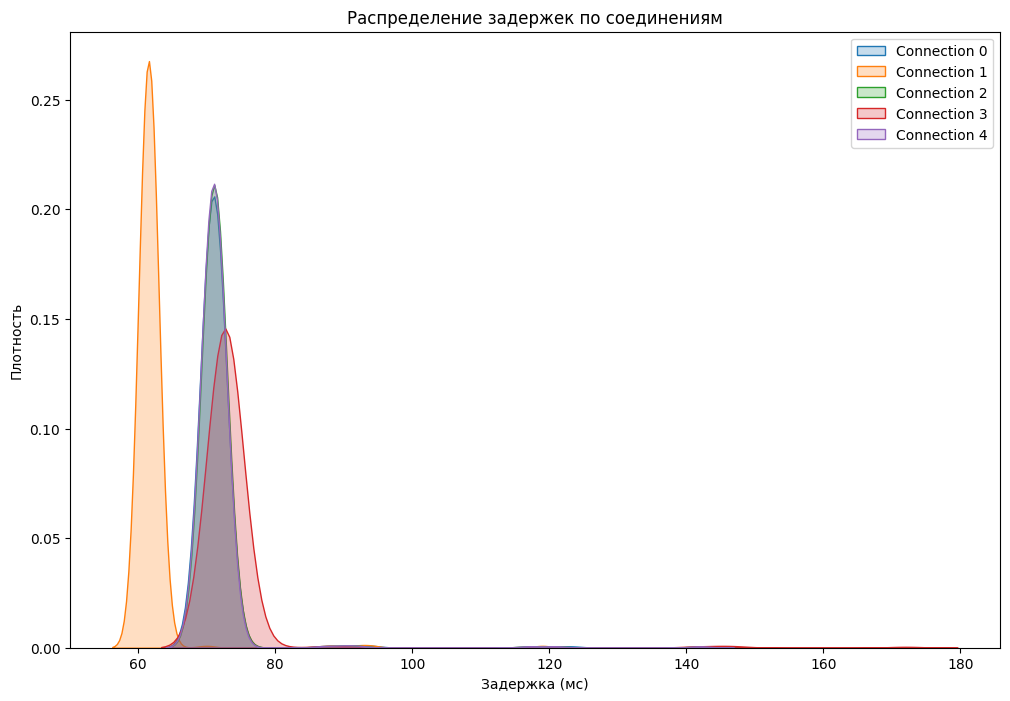

Доля быстрых обновлений по соединениям:
connection_id
1    0.976064
4    0.015957
3    0.007979
Name: count, dtype: float64
ANOVA тест на равенство средних значений задержек: F-статистика = 226.56458542156025, p-значение = 2.252395079859905e-158
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 200.98767133779313, p-значение = 2.30420635163502e-42


In [104]:
analyze_data(all_data)

* Распределение задержек по соединениям (KDE-график):
На графике KDE видно, что у соединения 1 (Connection 1) задержки распределены наиболее плотно и концентрируются в районе 60-65 мс, что объясняет его большую процентную долю в быстрых обновлений. Остальные соединения имеют более широкое распределение, особенно соединения 0, 2 и 3, что указывает на большую вариабельность в их задержках.
* Доля быстрых обновлений: Соединение 1 значительно доминирует, имея более 97% быстрых обновлений, что говорит о его явном преимуществе в производительности.
* ANOVA: F-статистика показывает, что средние задержки между соединениями значительно различаются, а низкое p-значение (практически нулевое) подтверждает статистическую значимость этих различий.
* Bartlett's Test: Тест на равенство дисперсий также показывает значительные различия между дисперсиями задержек соединений. Более наглядно это можно увидеть на Boxplot.

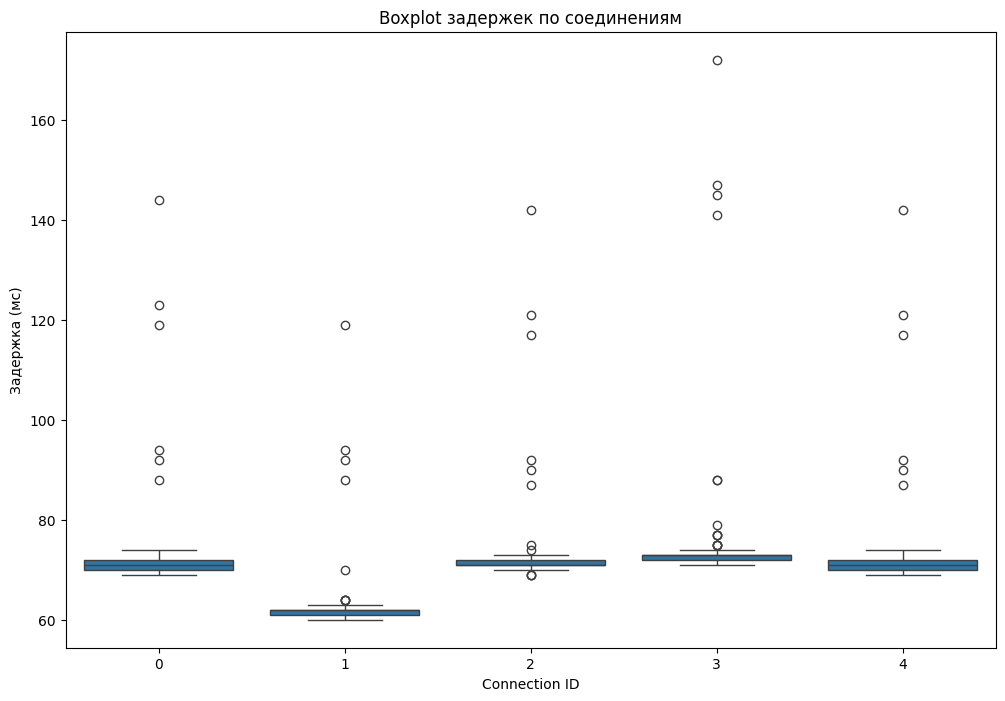

In [105]:
# Формирование boxplot задержек
df = create_data_frame(all_data)
def plot_boxplot(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="connection_id", y="delay", data=df)
    plt.title("Boxplot задержек по соединениям")
    plt.xlabel("Connection ID")
    plt.ylabel("Задержка (мс)")
    plt.show()

plot_boxplot(df)

* Boxplot: Соединение 1 явно показывает более низкие и стабильные задержки по сравнению с другими соединениями, что подтверждается небольшим количеством выбросов.
Остальные соединения имеют больше выбросов и большую дисперсию, что может быть связано с различными сетевыми или системными факторами.

Количество выбросов: 398
   connection_id  delay   receive_time     event_time
0              1     63  1725166153041  1725166152978
1              1     62  1725166153048  1725166152986
2              1     62  1725166153048  1725166152986
3              1     63  1725166153078  1725166153015
4              1     62  1725166153104  1725166153042


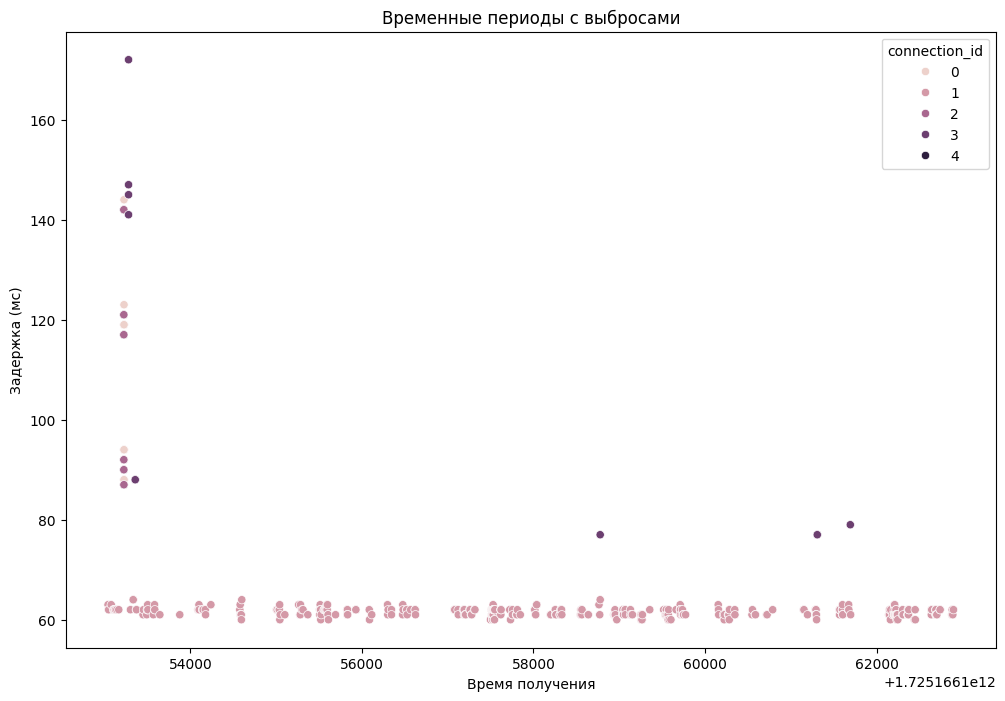

In [106]:
def analyze_outliers(df):
    # Найдем выбросы на основе IQR (межквартильного размаха)
    Q1 = df['delay'].quantile(0.25)
    Q3 = df['delay'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['delay'] < (Q1 - 1.5 * IQR)) | (df['delay'] > (Q3 + 1.5 * IQR))]
    
    # Печать количества выбросов и примерных временных промежутков
    print(f"Количество выбросов: {len(outliers)}")
    print(outliers[['connection_id', 'delay', 'receive_time', 'event_time']].head())
    
    # Визуализация выбросов во времени
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='receive_time', y='delay', hue='connection_id', data=outliers)
    plt.title("Временные периоды с выбросами")
    plt.xlabel("Время получения")
    plt.ylabel("Задержка (мс)")
    plt.show()
    return outliers
# Вызов функции после анализа данных
outliers = analyze_outliers(df)

* Анализ временных периодов: Временные периоды с выбросами показывают, что основные выбросы сконцентрированы в одном или нескольких временных интервалах.
Соединения 0 и 4 имеют заметные выбросы в разные моменты времени, что может указывать на проблемы, связанные с конкретными событиями в сети или нагрузкой на сервер.

/tmp/ipykernel_2914622/2392743545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers.loc[:, 'time_interval'] = outliers['receive_time'] // 10000


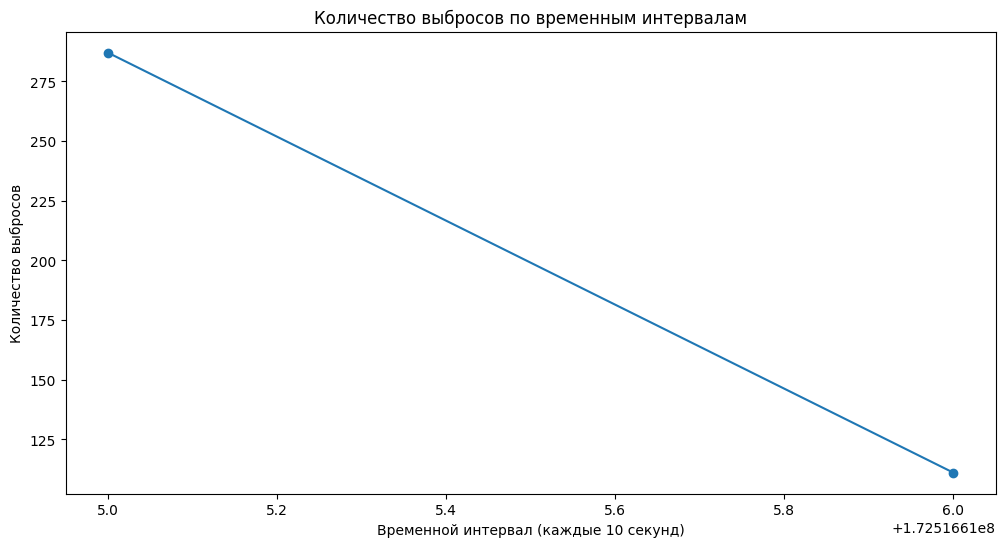

In [107]:
df['time_interval'] = df['receive_time'] // 10000  # Разделяем на интервалы по 10 секунд

# Подсчет количества выбросов в каждом интервале
outliers.loc[:, 'time_interval'] = outliers['receive_time'] // 10000
outliers_by_interval = outliers['time_interval'].value_counts().sort_index()

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(outliers_by_interval.index, outliers_by_interval.values, marker='o')
plt.title("Количество выбросов по временным интервалам")
plt.xlabel("Временной интервал (каждые 10 секунд)")
plt.ylabel("Количество выбросов")
plt.show()

* Количество выбросов по временным интервалам:
График показывает снижение количества выбросов с течением времени, что может говорить о стабилизации работы системы или снижении нагрузки.

# Промежуточные выводы
## Итоговый анализ данных:
* Соединение 1 имеет низкую латентность и, возможно, использует более быстрый и менее перегруженный маршрут для передачи данных. Это объясняет, почему у него меньше задержек и выбросов.
* Соединения 0, 2 и 3 могут сталкиваться с более высокими задержками из-за перегруженных маршрутов или высокой латентности на пути передачи данных. Это может быть вызвано сложными маршрутами, большим количеством узлов или географической удаленностью от серверов Binance.
## Что я под этим подрозумеваю:
1. Перегрузка маршрутов:
  Перегрузка маршрутов происходит, когда через них происходит передача большого количества данных. 
  Причины:

- В определенные моменты времени на определенных маршрутах может наблюдаться высокая загрузка трафика, например, во время пикового использования сети. В результате пакеты данных, передаваемые по этим маршрутам, могут быть задержаны.

-  Если данные проходят через несколько узлов (роутеров или серверов), каждый из которых может добавить собственную задержку, это увеличивает общее время передачи данных. Перегруженные узлы могут замедлять передачу данных и увеличивать задержки.

- Если маршрутизаторы или другие сетевые устройства на маршруте перегружены, они могут помещать входящие пакеты данных в очередь, прежде чем отправить их дальше. Это приводит к увеличению времени ожидания и, соответственно, к задержкам.

2. Высокая латентность:
Латентность (задержка) — это время, которое требуется для передачи данных от источника к получателю и обратно. Высокая латентность означает, что данные передаются медленно.

 - Физическое расстояние: Чем дальше данные должны перемещаться по сети (например, между континентами), тем больше будет латентность. Это связано с физическими ограничениями скорости света и технологическими задержками на оборудовании. Например сервер Binance находится в Японии а я подключаюсь из центральной америки поэтому очевидны что будут задержки.

- Сложные маршруты: Данные, проходящие через множество промежуточных узлов, будут задерживаться на каждом из них. Чем больше таких узлов, тем выше будет общая латентность. Этот фактор так же связан и с растоянием, чем дальше, тем больше узлов.

- Плохое качество сетевого оборудования: Если оборудование, через которое проходят данные (например, старые маршрутизаторы или кабели), не поддерживает высокоскоростную передачу данных, это может вызвать увеличение латентности.


## Как это проверить:
 - Трассировка маршрутов (traceroute): Как блеать посмотреть через питон маршрут да еще и к стриму пздц хз. А так можно конечно будет увидеть длину хотя бы и сделать вывод почему всегда один коннекшен быстрей.

 - Измерение ping: ВТоже в душе не ебу как глянуть пинг при таком подключении. Зато смогли бы определить какие маршруты медленные или происходит перегрузка сети.
